In [695]:
import pandas as pd
# Below options useful for showing more data when printing pandas displays
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
df = pd.read_csv('2014_v6b_USD.csv',low_memory=False)

In [696]:
df.shape

(1048575, 45)

In [697]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 45 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Date                        1048575 non-null  object 
 1   ISIN                        1048575 non-null  object 
 2   Ticker                      1048575 non-null  object 
 3   Issue_Currency              1048575 non-null  object 
 4   Tier                        1048575 non-null  object 
 5   Maturity                    1048575 non-null  object 
 6   Assumed_Maturity            27233 non-null    object 
 7   Coupon                      1001273 non-null  float64
 8   Dirty_Mid_Price             1042661 non-null  float64
 9   Mid_Price                   1048409 non-null  float64
 10  Bid_Ask_Price_Spread        1048409 non-null  float64
 11  Mid_YTW                     254192 non-null   float64
 12  Mid_YTM                     1041496 non-null  float64
 1

In [698]:
df.isnull().sum()

Date                                0
ISIN                                0
Ticker                              0
Issue_Currency                      0
Tier                                0
Maturity                            0
Assumed_Maturity              1021342
Coupon                          47302
Dirty_Mid_Price                  5914
Mid_Price                         166
Bid_Ask_Price_Spread              166
Mid_YTW                        794383
Mid_YTM                          7079
Benchmark_ISIN                   6559
Benchmark_Mid_YTM                7079
Spread_vs_Benchmark_Mid          7079
PV01                           231642
Mid_OAS                        908208
Mid_Z_Spread                   232034
Mid_Effective_Duration         369973
Mid_Macaulay_Duration          231645
Mid_Modified_Duration          231658
Mid_Effective_Convexity        369973
Mid_Convexity                  231658
Liquidity_Score                   704
evbIssue_Size                   12403
YieldToWorst

In [699]:
##deleted the duplicate data
##defination of duplicate data here: data with the same Date and ISIN
import pandas as pd

df = df.drop_duplicates(subset=['Date', 'ISIN'], keep='first')

df.to_csv('new_data_after_duplicate.csv', index=False)


In [700]:
fp1 = 'new_data_after_duplicate.csv'
dfn = pd.read_csv(fp1,low_memory=False)

In [701]:
dfn.shape

(1045869, 45)

In [702]:
##By ISIN, calculate the ratio of null values to the total number of rows in each group
dfn_isin_spread_nulls = df.groupby('ISIN')[['Mid_OAS', 'Mid_Z_Spread']].apply(lambda x: x.isnull().sum()/len(x))
dfn_isin_spread_nulls

,Mid_OAS,Mid_Z_Spread
ISIN,,
CA89352HAL39,0.000000,1.0
DE000A0LPMX0,1.000000,0.0
HK0000142494,1.000000,0.0
IL0011321416,0.456140,0.0
IL0011321747,0.833333,0.0
...,...,...
XS1106513762,1.000000,0.0
XS1110651012,1.000000,0.0
XS1111256431,1.000000,0.0


In [703]:
##derive the spread column
##derived spread：OAS for bonds with embedded options and mid_z_spread otherwise
oas_isins = dfn_isin_spread_nulls[dfn_isin_spread_nulls.Mid_OAS <= dfn_isin_spread_nulls.Mid_Z_Spread].index
dfn['spread_derived'] = dfn['Mid_Z_Spread']
dfn.loc[dfn.ISIN.isin(oas_isins), 'spread_derived'] = dfn.loc[dfn.ISIN.isin(oas_isins), 'Mid_OAS']
dfn['spread_derived']

0          136.19360
1          108.22644
2           72.83631
3          178.16030
4           89.88179
             ...    
1045864          NaN
1045865    783.86707
1045866    182.06516
1045867     30.14820
1045868    152.70410
Name: spread_derived, Length: 1045869, dtype: float64

In [704]:
##the 21 days shift in derived_spread for all bonds ！！

# Converts the 'Date' column to the datetime type
dfn['Date'] = pd.to_datetime(dfn['Date'])

# Defines the scroll window size
window_size = 21

# The definition function gets the lag value of the roll, which is processed according to the time interval condition
def compute_spread_shifted(group):
    valid_rows = group[group['Date'].diff() <= pd.Timedelta(days=1)]
    group['spread_shifted'] = valid_rows['spread_derived'].shift(window_size)
    return group

# Sort and group by 'ISIN' column, applying functions to each group
dfn = dfn.groupby('ISIN', group_keys=False).apply(compute_spread_shifted)
dfn

/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '13/01/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '14/01/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Parsing '15/01/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  cache_array = _maybe_cache(arg, format, cache, convert_listlike)
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning: Par

,Date,ISIN,Ticker,Issue_Currency,Tier,Maturity,Assumed_Maturity,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,Mid_YTW,Mid_YTM,Benchmark_ISIN,Benchmark_Mid_YTM,Spread_vs_Benchmark_Mid,PV01,Mid_OAS,Mid_Z_Spread,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,YieldToWorstOrMaturityDate,isTraceEligible,Trace_Trade_Count_10_Day,Trace_Trade_Count_30_Day,Defaulted,Country,Level_3,Level_4,Level_5,IBSector,Parent_Rating,IB_Security_Rating,watch_txt,IssueSubType,callNoticeDate,isCallable,isPuttable,IssueType,paymentCategorySubtype,spread_derived,spread_shifted
0,2014-01-01,US68268NAJ28,ONEOK,USD,SNRFOR,01/10/2022,NaN,3.375,94.49784,93.60722,0.48725,NaN,4.25836,US912828WE61,3.03466,122.37050,NaN,136.19360,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.000000e+08,01/10/2022,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil Equipment / Services & Distribution,Oil Equipment / Services & Distribution,Baa2,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,136.19360,NaN
1,2014-01-01,US68389XAL91,ORCLE,USD,SNRFOR,15/07/2040,NaN,5.375,109.41929,106.86617,0.77317,NaN,4.90916,US912810RC45,3.97585,93.33154,15.84249,NaN,108.22644,NaN,14.47907,14.13219,NaN,299.63213,5.0,2.250000e+09,15/07/2040,True,NaN,NaN,N,UNITED STATES OF AMERICA,Technology,Technology,Software & IT Services,Software & IT Services,A1,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,108.22644,NaN
2,2014-01-01,US637432MS19,NRUC,USD,SECDOM,01/11/2032,NaN,4.023,94.91334,94.18697,1.21479,NaN,4.48314,US912810RC45,3.97585,50.72963,NaN,72.83631,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.790000e+08,01/11/2032,True,NaN,NaN,N,UNITED STATES OF AMERICA,Financial Services,Financial Services,General Financial,Financial Services,A2,NaN,STA,Covered Bond,NaN,True,False,Bond,Fixed: Plain Vanilla Fixed Coupon,72.83631,NaN
3,2014-01-01,US577778CE17,M-RHI,USD,SNRFOR,15/07/2034,NaN,6.700,118.30068,115.19262,2.03080,NaN,5.46017,US912810RC45,3.97585,148.43207,13.90700,NaN,178.16030,NaN,11.75637,11.44394,NaN,193.59671,3.0,4.000000e+08,15/07/2034,True,NaN,NaN,N,UNITED STATES OF AMERICA,Consumer Services,Retail,General Retailers,General Retailers,WR,Baa3,NOO,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,178.16030,NaN
4,2014-01-01,US626717AE26,MUR,USD,SNRFOR,01/12/2017,NaN,3.500,101.40116,101.15811,0.29974,NaN,2.18850,US912828A750,1.74451,44.39936,3.78640,NaN,89.88179,NaN,3.73536,3.69492,NaN,16.22005,5.0,5.500000e+08,01/12/2017,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil & Gas Producers,Oil & Gas Producers,Baa3,Baa3,NEG,Bond,NaN,True,False,Bond,Variable: Step Up/Step Down,89.88179,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045864,2014-04-11,US816851AJ81,SRE,USD,SNRFOR,15/06/2018,NaN,6.150,116.79905,114.37321,0.18763,-111.31707,1.99770,US912828F627,1.62772,36.99757,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.000000e+08,15/12/2014,True,12.0,37.0,N,UNITED STATES OF AMERICA,Utilities,Utilities,Gas / Water & Multiutilities,Gas / Water & Multiutilities,Baa1,Baa1,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,NaN,NaN
1045865,2014-04-11,US870738AK76,SILVREAA,USD,SNRFOR,01/03/2022,NaN,7.875,89.97500,88.53125,1.06250,NaN,10.12752,US912828D564,2.33617,779.13500,4.94283,NaN,783.86707,4.70526,5.49433,5.22952,31.72071,36.16757,4.0,2.500000e+08,01/03/2022,True,237.0,763.0,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil & Gas Producers,Oil & Gas Producers,B2,B2,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,783.86707,NaN
1045866,2014-04-11,XS1022151416,TOWNFIN,USD,SUBLT2,31/12/2099,28/01/2019,NaN,106.68625,105.38000,0.50000,NaN,3.37273,US912828F627,1.62772,174.50056,4.09876,NaN,182.06516,NaN,3.84230,3.77860,NaN,18.07661,4.0,3.000000e+08,28/01/2019,True,NaN,NaN,N,HONG KONG,Utilities,Utilities,Gas / Wate

In [705]:
dfn['spread_derived'].isnull().sum()

124537

In [706]:
dfn['spread_shifted'].isnull().sum()

671669

In [707]:
##converting 'Parent_Rating', 'IB_Security_Rating', 'watch_txt' from categorical features into numerical features
rating_num_map = {  # use pd.map so all ratings not in map are nan
    'Aaa': 1, 
    'Aa1': 2, 
    'Aa2': 3, 
    'Aa3': 4, 
    'A1': 5, 
    'A2': 6, 
    'A3': 7, 
    'Baa1': 8, 
    'Baa2': 9,
    'Baa3': 10, 
    'Ba1': 11, 
    'Ba2': 12, 
    'Ba3': 13, 
    'B1': 14, 
    'B2': 15, 
    'B3': 16,
    'Caa1': 17, 
    'Caa2': 18, 
    'Caa3': 19, 
    'Ca': 20, 
    'C': 21,
}

watch_num_map = {  # use pd.map so all watch_txts not in map are nan
    'DNG': -2,
    'NEG': -1,
    'STA': 0, 
    'POS': 1,
    'UPG': 2,
}

dfn['security_rating_num'] = dfn['IB_Security_Rating'].map(rating_num_map)
dfn['parent_rating_num'] = dfn['Parent_Rating'].map(rating_num_map)
dfn['watch_txts_num'] = dfn['watch_txt'].map(watch_num_map)
dfn['watch_txts_num'].isnull().sum()

40773

In [708]:
##How to control the interval of 21 days is 21 days apart to make a difference is not necessarily 21 days

In [709]:
##converting 'Tier' from categorical features into numerical features
Tier_map={'SECDOM':1,
'SNRFOR':2,
'SNRLAC':3,
'SNRPRF':4,
'SUBLT2':5,
'JRSUBUT2':6,
'PREFT1':7}
dfn['Tier_num'] = dfn['Tier'].map(Tier_map)

In [710]:
##derive the Time to maturity column 
date_series = pd.to_datetime(dfn['Date'])
date_maturity_series=pd.to_datetime(dfn['Maturity'])
date_maturity_series-date_series
dfn['Time_to_maturity']=date_maturity_series-date_series

##derive the Time to assumed maturity column 
date_assumed_maturity_series=pd.to_datetime(dfn['Assumed_Maturity'])
dfn['Time_to_assumed_maturity']=date_assumed_maturity_series-date_series


/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '15/07/2040' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '15/07/2034' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '29/07/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '16/11/2016' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for

/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '31/01/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '14/09/2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '28/03/2014' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '21/09/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for

/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '17/04/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '22/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '22/04/2044' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '22/04/2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for

/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '24/06/2024' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '30/06/2017' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '16/06/2021' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '29/10/2022' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for

/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '20/04/2020' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '15/12/2065' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '15/07/2048' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  date_maturity_series=pd.to_datetime(dfn['Maturity'])
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3035285409.py:3: UserWarning: Parsing '16/09/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for

In [711]:
dfn.head(100)

,Date,ISIN,Ticker,Issue_Currency,Tier,Maturity,Assumed_Maturity,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,Mid_YTW,Mid_YTM,Benchmark_ISIN,Benchmark_Mid_YTM,Spread_vs_Benchmark_Mid,PV01,Mid_OAS,Mid_Z_Spread,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,YieldToWorstOrMaturityDate,isTraceEligible,Trace_Trade_Count_10_Day,Trace_Trade_Count_30_Day,Defaulted,Country,Level_3,Level_4,Level_5,IBSector,Parent_Rating,IB_Security_Rating,watch_txt,IssueSubType,callNoticeDate,isCallable,isPuttable,IssueType,paymentCategorySubtype,spread_derived,spread_shifted,security_rating_num,parent_rating_num,watch_txts_num,Tier_num,Time_to_maturity,Time_to_assumed_maturity
0,2014-01-01,US68268NAJ28,ONEOK,USD,SNRFOR,01/10/2022,NaN,3.375,94.49784,93.60722,0.48725,NaN,4.25836,US912828WE61,3.03466,122.37050,NaN,136.19360,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.000000e+08,01/10/2022,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil Equipment / Services & Distribution,Oil Equipment / Services & Distribution,Baa2,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,136.19360,NaN,NaN,9.0,0.0,2.0,2931 days,NaT
1,2014-01-01,US68389XAL91,ORCLE,USD,SNRFOR,15/07/2040,NaN,5.375,109.41929,106.86617,0.77317,NaN,4.90916,US912810RC45,3.97585,93.33154,15.84249,NaN,108.22644,NaN,14.47907,14.13219,NaN,299.63213,5.0,2.250000e+09,15/07/2040,True,NaN,NaN,N,UNITED STATES OF AMERICA,Technology,Technology,Software & IT Services,Software & IT Services,A1,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,108.22644,NaN,NaN,5.0,0.0,2.0,9692 days,NaT
2,2014-01-01,US637432MS19,NRUC,USD,SECDOM,01/11/2032,NaN,4.023,94.91334,94.18697,1.21479,NaN,4.48314,US912810RC45,3.97585,50.72963,NaN,72.83631,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.790000e+08,01/11/2032,True,NaN,NaN,N,UNITED STATES OF AMERICA,Financial Services,Financial Services,General Financial,Financial Services,A2,NaN,STA,Covered Bond,NaN,True,False,Bond,Fixed: Plain Vanilla Fixed Coupon,72.83631,NaN,NaN,6.0,0.0,1.0,6584 days,NaT
3,2014-01-01,US577778CE17,M-RHI,USD,SNRFOR,15/07/2034,NaN,6.700,118.30068,115.19262,2.03080,NaN,5.46017,US912810RC45,3.97585,148.43207,13.90700,NaN,178.16030,NaN,11.75637,11.44394,NaN,193.59671,3.0,4.000000e+08,15/07/2034,True,NaN,NaN,N,UNITED STATES OF AMERICA,Consumer Services,Retail,General Retailers,General Retailers,WR,Baa3,NOO,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,178.16030,NaN,10.0,NaN,NaN,2.0,7500 days,NaT
4,2014-01-01,US626717AE26,MUR,USD,SNRFOR,01/12/2017,NaN,3.500,101.40116,101.15811,0.29974,NaN,2.18850,US912828A750,1.74451,44.39936,3.78640,NaN,89.88179,NaN,3.73536,3.69492,NaN,16.22005,5.0,5.500000e+08,01/12/2017,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil & Gas Producers,Oil & Gas Producers,Baa3,Baa3,NEG,Bond,NaN,True,False,Bond,Variable: Step Up/Step Down,89.88179,NaN,10.0,10.0,-1.0,2.0,1107 days,NaT
5,2014-01-01,US50066CAF68,KORGAS,USD,SNRFOR,29/07/2018,NaN,2.875,102.29485,101.02506,0.42944,NaN,2.63465,US912828A750,1.74451,89.01383,4.34869,NaN,104.94356,NaN,4.25333,4.19803,NaN,22.38491,5.0,5.000000e+08,29/07/2018,True,NaN,NaN,N,KOREA (SOUTH),Utilities,Utilities,Gas / Water & Multiutilities,Gas / Water & Multiutilities,A1,A1,STA,Note,NaN,False,False,Note,Fixed: Plain Vanilla Fixed Coupon,104.94356,NaN,5.0,5.0,0.0,2.0,1670 days,NaT
6,2014-01-01,US50076QAY26,THEKRA,USD,SNRFOR,05/06/2017,NaN,2.250,101.96069,101.76694,0.16683,NaN,1.71471,US912828A594,0.76987,94.48376,3.36284,NaN,65.22881,NaN,3.30047,3.27241,NaN,12.84036,4.0,9.991400e+08,05/06/2017,True,NaN,NaN,N,UNITED STATES OF AMERICA,Consumer Goods,Food & Beverage,Food Producers,Food Producers,Baa2,Baa2,STA,Note,NaN,False,False,Note,Fixed: Plain Vanilla Fixed Coupon,65.22881,NaN,9.0,9.0,0.0,2.0,1221 days,NaT
7,2014-01-01,US50076QAZ90,THEKRA,USD,SNRFOR,06/06/2022,NaN,3.500,98.41079,98.11913,0.35398,NaN,3.76248,US912828WE61,3.03466,72.78243,7.21092,NaN,96.40672,NaN,7.32923,7.19390,

In [712]:
##Derived column for yield to worse and yield to maturity
##derived yield：YTW for bonds with embedded options and YTM otherwise
dfn_isin_yield_nulls = dfn.groupby('ISIN')[['Mid_YTW', 'Mid_YTM']].apply(lambda x: x.isnull().sum()/len(x))
yield_isins = dfn_isin_yield_nulls[dfn_isin_yield_nulls.Mid_YTW <= dfn_isin_yield_nulls.Mid_YTM].index
dfn['yield_derived'] = dfn['Mid_YTM']
dfn.loc[dfn.ISIN.isin(yield_isins), 'yield_derived'] = dfn.loc[dfn.ISIN.isin(yield_isins), 'Mid_YTW']

In [713]:
##Derived column for rating by IB security rating and parent rating 
##derived rating：IB security rating with embedded options and parent rating otherwise
dfn_isin_rating_nulls = dfn.groupby('ISIN')[['security_rating_num', 'parent_rating_num']].apply(lambda x: x.isnull().sum()/len(x))
rating_isins = dfn_isin_rating_nulls[dfn_isin_rating_nulls.security_rating_num <= dfn_isin_rating_nulls.parent_rating_num].index
dfn['rating_derived'] = dfn['parent_rating_num']
dfn.loc[dfn.ISIN.isin(rating_isins), 'rating_derived'] = dfn.loc[dfn.ISIN.isin(rating_isins), 'security_rating_num']

In [714]:
##DM=Developed Markets
DM = [
    'AUSTRALIA',
    'AUSTRIA',
    'BELGIUM',
    'BERMUDA',
    'BRITISH VIRGIN ISLANDS',
    'CANADA',
    'CAYMAN ISLANDS',
    'CYPRUS',
    'DENMARK',
    'FINLAND',
    'FRANCE',
    'GERMANY',
    'GREECE',
    'GUERNSEY',
    'HONG KONG',
    'ICELAND',
    'IRELAND',
    'ISLE OF MAN',
    'ISRAEL',
    'ITALY',
    'JAPAN',
    'JERSEY',
    'LUXEMBOURG',
    'MARSHALL ISLANDS',
    'NETHERLANDS',
    'NEW ZEALAND',
    'NORWAY',
    'PORTUGAL',
    'SINGAPORE',
    'SPAIN',
    'SUPRANATIONAL',
    'SWEDEN',
    'SWITZERLAND',
    'UNITED KINGDOM',
    'UNITED STATES OF AMERICA'
]
dfn['isDM'] = dfn['Country'].isin(DM)

In [715]:
dfn.head()

,Date,ISIN,Ticker,Issue_Currency,Tier,Maturity,Assumed_Maturity,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,Mid_YTW,Mid_YTM,Benchmark_ISIN,Benchmark_Mid_YTM,Spread_vs_Benchmark_Mid,PV01,Mid_OAS,Mid_Z_Spread,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,YieldToWorstOrMaturityDate,isTraceEligible,Trace_Trade_Count_10_Day,Trace_Trade_Count_30_Day,Defaulted,Country,Level_3,Level_4,Level_5,IBSector,Parent_Rating,IB_Security_Rating,watch_txt,IssueSubType,callNoticeDate,isCallable,isPuttable,IssueType,paymentCategorySubtype,spread_derived,spread_shifted,security_rating_num,parent_rating_num,watch_txts_num,Tier_num,Time_to_maturity,Time_to_assumed_maturity,yield_derived,rating_derived,isDM
0,2014-01-01,US68268NAJ28,ONEOK,USD,SNRFOR,01/10/2022,NaN,3.375,94.49784,93.60722,0.48725,NaN,4.25836,US912828WE61,3.03466,122.37050,NaN,136.19360,NaN,NaN,NaN,NaN,NaN,NaN,5.0,9.000000e+08,01/10/2022,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil Equipment / Services & Distribution,Oil Equipment / Services & Distribution,Baa2,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,136.19360,NaN,NaN,9.0,0.0,2.0,2931 days,NaT,4.25836,9.0,True
1,2014-01-01,US68389XAL91,ORCLE,USD,SNRFOR,15/07/2040,NaN,5.375,109.41929,106.86617,0.77317,NaN,4.90916,US912810RC45,3.97585,93.33154,15.84249,NaN,108.22644,NaN,14.47907,14.13219,NaN,299.63213,5.0,2.250000e+09,15/07/2040,True,NaN,NaN,N,UNITED STATES OF AMERICA,Technology,Technology,Software & IT Services,Software & IT Services,A1,NaN,STA,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,108.22644,NaN,NaN,5.0,0.0,2.0,9692 days,NaT,4.90916,5.0,True
2,2014-01-01,US637432MS19,NRUC,USD,SECDOM,01/11/2032,NaN,4.023,94.91334,94.18697,1.21479,NaN,4.48314,US912810RC45,3.97585,50.72963,NaN,72.83631,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.790000e+08,01/11/2032,True,NaN,NaN,N,UNITED STATES OF AMERICA,Financial Services,Financial Services,General Financial,Financial Services,A2,NaN,STA,Covered Bond,NaN,True,False,Bond,Fixed: Plain Vanilla Fixed Coupon,72.83631,NaN,NaN,6.0,0.0,1.0,6584 days,NaT,4.48314,6.0,True
3,2014-01-01,US577778CE17,M-RHI,USD,SNRFOR,15/07/2034,NaN,6.700,118.30068,115.19262,2.03080,NaN,5.46017,US912810RC45,3.97585,148.43207,13.90700,NaN,178.16030,NaN,11.75637,11.44394,NaN,193.59671,3.0,4.000000e+08,15/07/2034,True,NaN,NaN,N,UNITED STATES OF AMERICA,Consumer Services,Retail,General Retailers,General Retailers,WR,Baa3,NOO,Note,NaN,True,False,Note,Fixed: Plain Vanilla Fixed Coupon,178.16030,NaN,10.0,NaN,NaN,2.0,7500 days,NaT,5.46017,10.0,True
4,2014-01-01,US626717AE26,MUR,USD,SNRFOR,01/12/2017,NaN,3.500,101.40116,101.15811,0.29974,NaN,2.18850,US912828A750,1.74451,44.39936,3.78640,NaN,89.88179,NaN,3.73536,3.69492,NaN,16.22005,5.0,5.500000e+08,01/12/2017,True,NaN,NaN,N,UNITED STATES OF AMERICA,Oil & Gas,Oil & Gas,Oil & Gas Producers,Oil & Gas Producers,Baa3,Baa3,NEG,Bond,NaN,True,False,Bond,Variable: Step Up/Step Down,89.88179,NaN,10.0,10.0,-1.0,2.0,1107 days,NaT,2.18850,10.0,True


In [716]:
## Delete all unneeded columns (including those that have been replaced or modified) 

dfn=dfn.drop('Ticker',axis=1)
dfn=dfn.drop('Issue_Currency',axis=1)
dfn=dfn.drop('Tier',axis=1)
dfn=dfn.drop('Maturity',axis=1)
dfn=dfn.drop('Assumed_Maturity',axis=1)
dfn=dfn.drop('Mid_YTW',axis=1)
dfn=dfn.drop('Mid_YTM',axis=1)
dfn=dfn.drop('Benchmark_ISIN',axis=1)
dfn=dfn.drop('Benchmark_Mid_YTM',axis=1)
dfn=dfn.drop('Spread_vs_Benchmark_Mid',axis=1)
dfn=dfn.drop('Mid_OAS',axis=1)
dfn=dfn.drop('Mid_Z_Spread',axis=1)
dfn=dfn.drop('YieldToWorstOrMaturityDate',axis=1)
dfn=dfn.drop('isTraceEligible',axis=1)
dfn=dfn.drop('Trace_Trade_Count_10_Day',axis=1)
dfn=dfn.drop('Trace_Trade_Count_30_Day',axis=1)
dfn=dfn.drop('Defaulted',axis=1)
dfn=dfn.drop('Country',axis=1)
dfn=dfn.drop('Level_3',axis=1)
dfn=dfn.drop('Level_4',axis=1)
dfn=dfn.drop('Level_5',axis=1)
dfn=dfn.drop('IBSector',axis=1)
dfn=dfn.drop('Parent_Rating',axis=1)
dfn=dfn.drop('IB_Security_Rating',axis=1)
dfn=dfn.drop('watch_txt',axis=1)
dfn=dfn.drop('IssueSubType',axis=1)
dfn=dfn.drop('callNoticeDate',axis=1)
dfn=dfn.drop('IssueType',axis=1)
dfn=dfn.drop('paymentCategorySubtype',axis=1)
dfn=dfn.drop('security_rating_num',axis=1)
dfn=dfn.drop('parent_rating_num',axis=1)
dfn=dfn.drop('Time_to_assumed_maturity',axis=1)


In [718]:
##Only keep lines that shifted the exact value shifted
dfn = dfn.dropna(subset=['spread_shifted'])
dfn.shape

(374200, 24)

# Data preprocess

In [730]:
###Convert days to int type (2931 days -> 2931)
dfn["Time_to_maturity"] = dfn["Time_to_maturity"].apply(lambda e:int(str(e).split()[0]))

dfn.head()

,ISIN,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,PV01,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,isCallable,isPuttable,spread_derived,spread_shifted,watch_txts_num,Tier_num,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-02-27,XS0221448557,5.100,105.34138,104.13721,0.06410,1.29453,1.28207,1.22785,1.21706,2.22554,2.39753,4.0,3.500000e+08,False,False,147.50829,160.72792,0.0,2.0,556,1.77305,8.0,False
2014-02-27,XS0259110327,5.100,112.33266,111.26738,0.26920,2.46158,2.44724,2.18918,2.17856,6.74800,6.39860,5.0,5.000000e+08,False,False,43.05334,41.94132,0.0,2.0,853,0.97455,2.0,True
2014-02-27,USY1004WAA46,12.500,107.19444,105.25000,1.00000,1.35134,2.44724,1.26052,1.21046,6.74800,2.28555,5.0,3.500000e+08,True,False,780.68463,748.17786,-1.0,1.0,526,5.90576,14.0,False
2014-02-27,USY71548AX22,5.875,99.32302,98.81712,1.78436,12.25237,11.89534,12.33410,11.97642,202.90758,205.29196,3.0,3.500000e+08,False,False,262.45627,249.38742,0.0,2.0,7679,5.97311,8.0,False
2014-02-27,USG8200QAB26,4.375,102.21371,100.52447,0.70467,7.99985,7.82969,7.82508,7.66011,72.44398,73.77032,5.0,1.500000e+09,True,False,165.27016,157.31947,0.0,2.0,3519,4.30727,4.0,False


In [ ]:
##Set Date to index
dfn = dfn.set_index("Date")
dfn.head()

In [721]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374200 entries, 2014-02-27 to 2014-03-11
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ISIN                     374200 non-null  object 
 1   Coupon                   357401 non-null  float64
 2   Dirty_Mid_Price          373483 non-null  float64
 3   Mid_Price                374181 non-null  float64
 4   Bid_Ask_Price_Spread     374181 non-null  float64
 5   PV01                     325297 non-null  float64
 6   Mid_Effective_Duration   299641 non-null  float64
 7   Mid_Macaulay_Duration    325301 non-null  float64
 8   Mid_Modified_Duration    325290 non-null  float64
 9   Mid_Effective_Convexity  299641 non-null  float64
 10  Mid_Convexity            325290 non-null  float64
 11  Liquidity_Score          374146 non-null  float64
 12  evbIssue_Size            370101 non-null  float64
 13  isCallable               374200 non-null  b

In [731]:
##The mode is used to fill Boolean variables
columns_to_fill = ['isCallable', 'isPuttable','isDM']

# Loop over the specified column
for col in columns_to_fill:
    mode_value = dfn[col].mode()[0]
    dfn[col] = dfn[col].fillna(mode_value)


In [732]:
## Linear interpolation is used to fill numeric missing values
## Linear interpolation is suitable for continuous numerical data, 
#especially time series data (this data is panel time series). It can be used to fill in missing values, smooth data, generate estimates, and more.
## The basic idea of linear interpolation is to estimate the value of the unknown data points through the linear relationship between the known data points.
columns_to_interpolate = [col for col in dfn.columns if col not in ['isCallable', 'isPuttable', 'isDM']]

# Use the 'pad' method for forward padding, followed by linear interpolation
dfn[columns_to_interpolate] = dfn[columns_to_interpolate].fillna(method='pad').interpolate(method='linear', axis=0)



In [733]:
dfn.isna().sum()

ISIN                       0
Coupon                     0
Dirty_Mid_Price            0
Mid_Price                  0
Bid_Ask_Price_Spread       0
PV01                       0
Mid_Effective_Duration     0
Mid_Macaulay_Duration      0
Mid_Modified_Duration      0
Mid_Effective_Convexity    0
Mid_Convexity              0
Liquidity_Score            0
evbIssue_Size              0
isCallable                 0
isPuttable                 0
spread_derived             0
spread_shifted             0
watch_txts_num             0
Tier_num                   0
Time_to_maturity           0
yield_derived              0
rating_derived             0
isDM                       0
dtype: int64

In [743]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 374200 entries, 2014-02-27 to 2014-03-11
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   ISIN                     374200 non-null  object 
 1   Coupon                   374200 non-null  float64
 2   Dirty_Mid_Price          374200 non-null  float64
 3   Mid_Price                374200 non-null  float64
 4   Bid_Ask_Price_Spread     374200 non-null  float64
 5   PV01                     374200 non-null  float64
 6   Mid_Effective_Duration   374200 non-null  float64
 7   Mid_Macaulay_Duration    374200 non-null  float64
 8   Mid_Modified_Duration    374200 non-null  float64
 9   Mid_Effective_Convexity  374200 non-null  float64
 10  Mid_Convexity            374200 non-null  float64
 11  Liquidity_Score          374200 non-null  float64
 12  evbIssue_Size            374200 non-null  float64
 13  isCallable               374200 non-null  b

In [744]:
####Regarding features involving character types, while trying to retain features as much as possible,
##delete features with excessive categories to facilitate subsequent one-hot encoding conversion.
select_col = []
for col in dfn.columns:
    if dfn[col].dtype not in ["float64",'int64']:
        if len(set(dfn[col].values)) <= 1000:
            select_col.append(col)
    else:
        select_col.append(col)
select_col
          
            

['Coupon',
 'Dirty_Mid_Price',
 'Mid_Price',
 'Bid_Ask_Price_Spread',
 'PV01',
 'Mid_Effective_Duration',
 'Mid_Macaulay_Duration',
 'Mid_Modified_Duration',
 'Mid_Effective_Convexity',
 'Mid_Convexity',
 'Liquidity_Score',
 'evbIssue_Size',
 'isCallable',
 'isPuttable',
 'spread_derived',
 'spread_shifted',
 'watch_txts_num',
 'Tier_num',
 'Time_to_maturity',
 'yield_derived',
 'rating_derived',
 'isDM']

In [745]:
df2 = dfn[select_col]
dfn

,ISIN,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,PV01,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,isCallable,isPuttable,spread_derived,spread_shifted,watch_txts_num,Tier_num,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-02-27,XS0221448557,5.100,105.34138,104.13721,0.06410,1.29453,1.28207,1.22785,1.21706,2.22554,2.39753,4.0,3.500000e+08,False,False,147.50829,160.72792,0.0,2.0,556,1.77305,8.0,False
2014-02-27,XS0259110327,5.100,112.33266,111.26738,0.26920,2.46158,2.44724,2.18918,2.17856,6.74800,6.39860,5.0,5.000000e+08,False,False,43.05334,41.94132,0.0,2.0,853,0.97455,2.0,True
2014-02-27,USY1004WAA46,12.500,107.19444,105.25000,1.00000,1.35134,2.44724,1.26052,1.21046,6.74800,2.28555,5.0,3.500000e+08,True,False,780.68463,748.17786,-1.0,1.0,526,5.90576,14.0,False
2014-02-27,USY71548AX22,5.875,99.32302,98.81712,1.78436,12.25237,11.89534,12.33410,11.97642,202.90758,205.29196,3.0,3.500000e+08,False,False,262.45627,249.38742,0.0,2.0,7679,5.97311,8.0,False
2014-02-27,USG8200QAB26,4.375,102.21371,100.52447,0.70467,7.99985,7.82969,7.82508,7.66011,72.44398,73.77032,5.0,1.500000e+09,True,False,165.27016,157.31947,0.0,2.0,3519,4.30727,4.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-11,USU65584AL54,5.750,107.62731,105.85439,0.09877,1.23872,1.23460,1.15171,1.14711,2.06492,2.27086,4.0,5.000000e+08,True,False,41.58046,36.65982,0.0,2.0,675,0.80269,8.0,True
2014-03-11,USU7185PAA13,4.300,107.45830,107.04025,0.87000,6.91214,6.80401,6.43380,6.33176,50.41823,47.52470,4.0,2.000000e+09,True,False,105.47750,92.79663,0.0,2.0,2856,-12.26451,7.0,True
2014-03-11,USU9312CAD66,11.000,47.25278,46.00000,2.00000,1.63926,1.40651,3.46903,2.97656,6.11627,13.23459,4.0,3.500000e+08,True,False,2900.69750,1607.90360,0.0,1.0,2125,33.10050,19.0,True


In [746]:
##Filter outliers by quartile
def remove_outliers(df, features):
    # Create a copy of df to avoid modifying the original data
    df = df.copy()
    
    for feature in features:
        # Calculate the quartile of the feature
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        
        # Calculate the interquartile distance
        IQR = Q3 - Q1

        # Computed upper and lower boundaries
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Filter outliers using Boolean indexes
        filtered_entries = (df[feature] >= lower_bound) & (df[feature] <= upper_bound)
        df = df[filtered_entries]
    
    return df

In [750]:
features = []
for col in dfn.columns:
    dtype = dfn[col].dtype
    if dtype == "float64":
        features.append(col)      

In [752]:
clean_df = remove_outliers(dfn, features)

In [753]:
clean_df

,ISIN,Coupon,Dirty_Mid_Price,Mid_Price,Bid_Ask_Price_Spread,PV01,Mid_Effective_Duration,Mid_Macaulay_Duration,Mid_Modified_Duration,Mid_Effective_Convexity,Mid_Convexity,Liquidity_Score,evbIssue_Size,isCallable,isPuttable,spread_derived,spread_shifted,watch_txts_num,Tier_num,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,,,,,,,,,,,,,,,,,
2014-02-27,XS0221448557,5.100,105.34138,104.13721,0.06410,1.29453,1.28207,1.22785,1.21706,2.22554,2.39753,4.0,3.500000e+08,False,False,147.50829,160.72792,0.0,2.0,556,1.77305,8.0,False
2014-02-27,XS0259110327,5.100,112.33266,111.26738,0.26920,2.46158,2.44724,2.18918,2.17856,6.74800,6.39860,5.0,5.000000e+08,False,False,43.05334,41.94132,0.0,2.0,853,0.97455,2.0,True
2014-02-27,USG8200QAB26,4.375,102.21371,100.52447,0.70467,7.99985,7.82969,7.82508,7.66011,72.44398,73.77032,5.0,1.500000e+09,True,False,165.27016,157.31947,0.0,2.0,3519,4.30727,4.0,False
2014-02-27,US03070QAM33,7.500,112.19270,109.29687,0.84375,6.24983,6.06958,5.56902,5.40996,41.42894,38.95577,4.0,8.000000e+08,True,False,373.07138,354.94077,0.0,2.0,2604,5.88028,11.0,True
2014-02-27,US021441AF71,4.100,102.75766,101.35682,0.80648,8.22536,8.06476,8.00253,7.84833,75.67204,75.97177,4.0,4.000000e+08,True,False,125.81268,129.47333,0.0,2.0,3548,3.92963,8.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-03-11,US902133AM92,3.500,104.04509,103.14092,0.32897,6.68061,6.57947,6.41895,6.32367,48.24996,47.98345,4.0,5.000000e+08,True,False,85.29928,93.56045,0.0,2.0,2913,3.01347,8.0,True
2014-03-11,US907818DY13,3.250,101.25916,100.50083,0.43337,8.80643,8.66738,8.69621,8.55960,86.47970,88.00207,5.0,3.500000e+08,True,False,70.22755,60.51852,0.0,2.0,3963,3.19186,7.0,True
2014-03-11,XS0728761726,7.875,107.70833,106.25000,0.30000,2.26513,4.84164,2.10239,2.07802,32.75876,6.07794,5.0,3.500000e+08,False,False,152.76788,151.35664,0.0,2.0,1052,2.34542,10.0,True


In [755]:
clean_df1=clean_df.drop('ISIN',axis=1)

# View feature correlations

/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


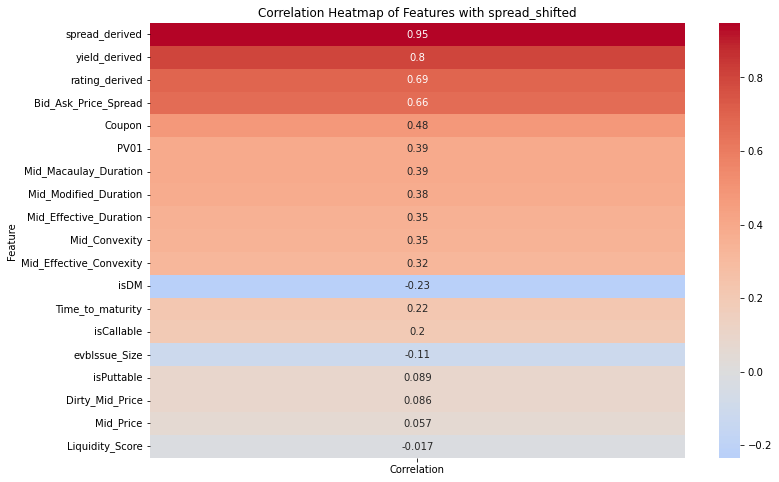

In [756]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'clean_df' is your DataFrame
# Extract the values from the 'spread_shifted' column
spread_shifted_values = clean_df1['spread_shifted'].values

# Compute the correlation coefficients
correlations = {}
for column in clean_df1.columns:
    if column != 'spread_shifted':
        correlations[column] = np.corrcoef(clean_df1[column].values, spread_shifted_values)[0, 1]

# Filter out NaN values and sort by the absolute value of the correlation coefficient in descending order
sorted_correlations = sorted([item for item in correlations.items() if not np.isnan(item[1])], key=lambda x: abs(x[1]), reverse=True)

# Create a DataFrame from the sorted correlations
corr_df = pd.DataFrame(sorted_correlations, columns=['Feature', 'Correlation'])

# Generate a heatmap for the sorted correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df.set_index('Feature'), annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Features with spread_shifted')
plt.show()


# xgboost internal structure for feature selection

                    Feature  Importance
17            yield_derived    0.592119
19                     isDM    0.115924
18           rating_derived    0.114856
16         Time_to_maturity    0.090561
0                    Coupon    0.017602
9             Mid_Convexity    0.010991
7     Mid_Modified_Duration    0.008885
11            evbIssue_Size    0.007561
5    Mid_Effective_Duration    0.005573
10          Liquidity_Score    0.005105
4                      PV01    0.004769
3      Bid_Ask_Price_Spread    0.004642
2                 Mid_Price    0.004585
12               isCallable    0.004533
8   Mid_Effective_Convexity    0.004364
6     Mid_Macaulay_Duration    0.003363
1           Dirty_Mid_Price    0.002814
13               isPuttable    0.001754
14           watch_txts_num    0.000000
15                 Tier_num    0.000000


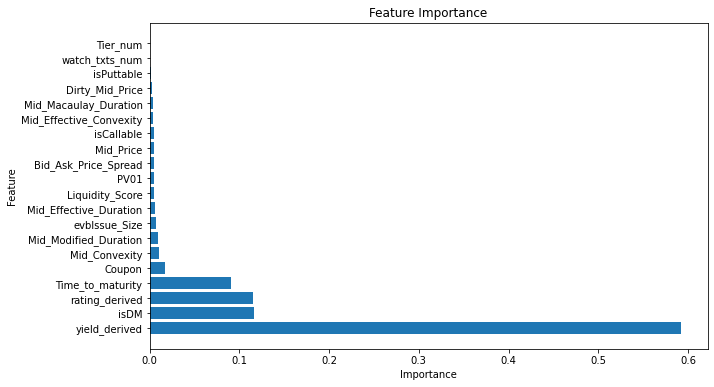

In [758]:
import pandas as pd
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Prepare the data and labels
X = clean_df1.drop(columns=['spread_shifted', 'spread_derived'])  # Replace 'target_column' with your target column name
y = clean_df1['spread_shifted']

# Check the data type of the target column
if y.dtypes == 'float64':
    # If the target column has continuous values, treat it as a regression problem
    model = xgb.XGBRegressor()
else:
    # If the target column has integer values, treat it as a classification problem
    model = xgb.XGBClassifier()

# Build the XGBoost model
model.fit(X, y)

# Get the feature importances
feature_importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
print(feature_importance_df)

# Plot the feature importance chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.show()


# Rescreen features

In [759]:
clean_df=clean_df.drop('spread_derived',axis=1)
clean_df=clean_df.drop('Tier_num',axis=1)
clean_df=clean_df.drop('watch_txts_num',axis=1)
clean_df=clean_df.drop('Mid_Macaulay_Duration',axis=1)
clean_df=clean_df.drop('Liquidity_Score',axis=1)
clean_df=clean_df.drop('Mid_Effective_Convexity',axis=1)
clean_df=clean_df.drop('Mid_Convexity',axis=1)
clean_df=clean_df.drop('isCallable',axis=1)
clean_df=clean_df.drop('Mid_Modified_Duration',axis=1)
clean_df=clean_df.drop('evbIssue_Size',axis=1)
clean_df=clean_df.drop('isPuttable',axis=1)
clean_df=clean_df.drop('Mid_Effective_Duration',axis=1)
clean_df=clean_df.drop('Dirty_Mid_Price',axis=1)
clean_df=clean_df.drop('Mid_Price',axis=1)


In [760]:
clean_df.head()

,ISIN,Coupon,Bid_Ask_Price_Spread,PV01,spread_shifted,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,,,
2014-02-27,XS0221448557,5.100,0.06410,1.29453,160.72792,556,1.77305,8.0,False
2014-02-27,XS0259110327,5.100,0.26920,2.46158,41.94132,853,0.97455,2.0,True
2014-02-27,USG8200QAB26,4.375,0.70467,7.99985,157.31947,3519,4.30727,4.0,False
2014-02-27,US03070QAM33,7.500,0.84375,6.24983,354.94077,2604,5.88028,11.0,True
2014-02-27,US021441AF71,4.100,0.80648,8.22536,129.47333,3548,3.92963,8.0,True


# Balance the dataset

In [761]:
clean_df

,ISIN,Coupon,Bid_Ask_Price_Spread,PV01,spread_shifted,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,,,
2014-02-27,XS0221448557,5.100,0.06410,1.29453,160.72792,556,1.77305,8.0,False
2014-02-27,XS0259110327,5.100,0.26920,2.46158,41.94132,853,0.97455,2.0,True
2014-02-27,USG8200QAB26,4.375,0.70467,7.99985,157.31947,3519,4.30727,4.0,False
2014-02-27,US03070QAM33,7.500,0.84375,6.24983,354.94077,2604,5.88028,11.0,True
2014-02-27,US021441AF71,4.100,0.80648,8.22536,129.47333,3548,3.92963,8.0,True
...,...,...,...,...,...,...,...,...,...
2014-03-11,US902133AM92,3.500,0.32897,6.68061,93.56045,2913,3.01347,8.0,True
2014-03-11,US907818DY13,3.250,0.43337,8.80643,60.51852,3963,3.19186,7.0,True
2014-03-11,XS0728761726,7.875,0.30000,2.26513,151.35664,1052,2.34542,10.0,True


In [762]:
#!pip install xgboost
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# split the data according the time series

In [833]:
import pandas as pd

def split_train_test_by_group(df, group_col, train_frac=0.8):
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

    for name, group in df.groupby(group_col):
        train_size = int(len(group) * train_frac)
        train_group = group.iloc[:train_size]
        test_group = group.iloc[train_size:]
        
        train_df = pd.concat([train_df, train_group])
        test_df = pd.concat([test_df, test_group])

    return train_df, test_df

# Assume clean df2 is your raw data
train_df, test_df = split_train_test_by_group(clean_df, 'ISIN')

# Assume clean df2 is your raw data
X_train = train_df.drop(["spread_shifted"], axis=1)
y_train = train_df["spread_shifted"]

X_test = test_df.drop(["spread_shifted"], axis=1)
y_test = test_df["spread_shifted"]


In [835]:
X_train1=X_train.drop('ISIN',axis=1).values
y_train1 = y_train.values

X_test1 =X_test.drop('ISIN',axis=1).values
y_test1 = y_test.values


In XGBoost, you can select an appropriate loss function based on the specific problem type. XGBoost supports various loss functions, including the following:

reg:squarederror (default): Suitable for regression problems, using squared error as the loss function.

reg:logistic: Suitable for binary classification problems, using the logarithmic loss function.

binary:logistic: Suitable for binary classification problems, using the binary logistic regression loss function.

binary:logitraw: Suitable for binary classification problems, outputting the raw scores before applying the sigmoid transformation.

multi:softmax: Suitable for multi-class classification problems, using the softmax function to compute class probabilities and using the cross-entropy loss function.

multi:softprob: Suitable for multi-class classification problems, similar to multi:softmax, but outputting the probability distribution for each class instead of class labels.

In [820]:
##Since we are dealing with a regression problem, the default loss function used is reg:squarederror.

In [821]:
X_train1

array([[5.0, 1.64978, 2.23409, ..., 4.68777, 7.0, True],
       [5.0, 1.62031, 2.17965, ..., 4.76339, 7.0, True],
       [5.0, 1.60484, 5.86979, ..., 4.80501, 7.0, True],
       ...,
       [2.875, 0.47188, 4.47526, ..., 2.79257, 5.0, False],
       [3.0, 0.36115, 4.5771, ..., 2.79338, 6.0, False],
       [3.0, 0.36271, 4.59496, ..., 2.70968, 6.0, False]], dtype=object)

# Model parameter tuning

In [822]:
#!pip install scikit-learn
from sklearn.model_selection import GridSearchCV

# define model
model = xgb.XGBRegressor()
# define parameter grid
param_grid = {
   'learning_rate': [0.1, 0.01],
    'n_estimators': [50,100,150],
    'max_depth': [5,7,9],
    'subsample': [0.6, 0.8,1],
    'reg_lambda': [0.1, 0.5,1]
}

# Tuning using grid search, this step includes feature fitting
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,n_jobs =1)
grid_search.fit(X_train1, y_train1)


GridSearchCV(cv=2,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estim

In [823]:
# The optimal parameters and evaluation results are obtained
print("Best parameters found: ", grid_search.best_params_)

###obtain the optimal model
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test1)

Best parameters found:  {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150, 'reg_lambda': 0.5, 'subsample': 0.6}


In [791]:
###best_model = xgb.XGBRegressor(learning_rate=0.1,max_depth=7,n_estimators=150,reg_lambda=0.1,subsample=0.8)
###best_model.fit(X_train, y_train)

# Model Evaluation

Mean Squared Error (MSE):" calculates the average squared difference between predicted values and actual values. A smaller MSE is better and reflects the model's prediction accuracy.

"Root Mean Squared Error (RMSE):" is the square root of the MSE and has the same units as the original data. A smaller RMSE is better, similar to MSE, and indicates the model's prediction accuracy.

"Mean Absolute Error (MAE):" computes the average absolute difference between predicted values and actual values. A smaller MAE is better and reflects the magnitude of the average prediction error of the model.

"Coefficient of Determination (R-squared):" also known as the goodness of fit, represents the proportion of the target variable's variance explained by the model. It ranges from 0 to 1, where a value closer to 1 indicates a better fit of the model, while a lower value suggests poorer fit.


In [824]:
# Evaluate model performance
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


# MSE
mse = mean_squared_error(y_test1, predictions)
print("Mean Squared Error (MSE):", mse)

# RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# MAE
mae = mean_absolute_error(y_test1, predictions)
print("Mean Absolute Error (MAE):", mae)

# R-squared
r2 = r2_score(y_test1, predictions)
print("R-squared:", r2)

Mean Squared Error (MSE): 679.0544320219567
Root Mean Squared Error (RMSE): 26.058672875301166
Mean Absolute Error (MAE): 18.39891180378814
R-squared: 0.9218152450772085


In [825]:
##Give the importance of primary features
importance = best_model.get_booster().get_score(importance_type='weight')

feature_names = list(clean_df1.columns)  # Assuming X is your feature data, obtain the feature names.

feature_importance = {feature_names[int(i[1:])] : importance[i] for i in importance}

print(feature_importance)

{'Coupon': 672.0, 'Dirty_Mid_Price': 504.0, 'Mid_Price': 677.0, 'Bid_Ask_Price_Spread': 836.0, 'PV01': 893.0, 'Mid_Effective_Duration': 464.0, 'Mid_Macaulay_Duration': 142.0}


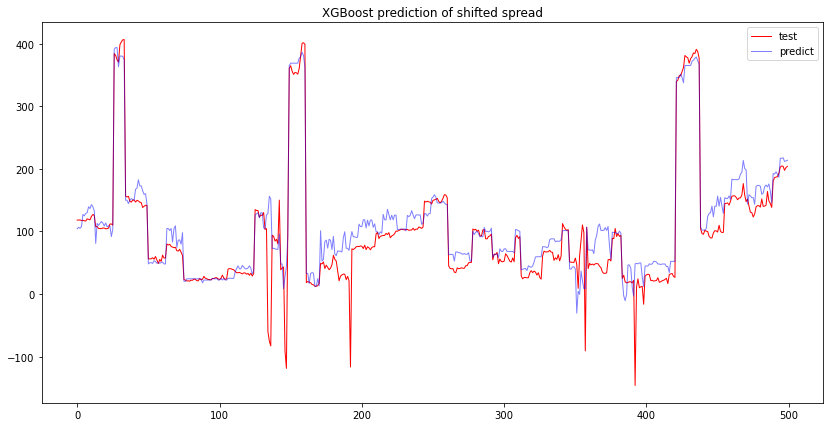

In [826]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(range(len(y_test[:500])),y_test[:500],color="red",label="test",lw=1)
plt.plot(range(len(predictions[:500])),predictions[:500],color="b",label="predict",lw=1,alpha=0.5)
plt.legend()
plt.title('XGBoost prediction of shifted spread')
plt.show()
plt.close()

In [132]:
##Visualizing the alignment between predicted and actual values, 
#the distribution of predictions versus actual distribution, reveals that the model's performance is moderate.

# KS-test

The KS statistic ranges from 0 to 1. A KS statistic close to 0 indicates a high degree of similarity between the distributions of two samples, while a KS statistic close to 1 indicates a significant difference between their distributions.

In the context of the KS test, we typically use the KS statistic along with a significance level (usually chosen as 0.001，0.01 or 0.05) to make decisions. If the KS statistic is greater than the chosen significance level, we can reject the null hypothesis, which implies that the two samples do not come from the same distribution. Conversely, if the KS statistic is less than or equal to the chosen significance level, we cannot reject the null hypothesis, suggesting that the two samples may come from the same distribution

In [ ]:
###KS statistic greater than 0.05 The predicted distribution is different from the actual distribution
# import numpy as np
from scipy.stats import kstest

#KS-Test
statistic, p_value = kstest(y_test, predictions)

print("KS statistic:", statistic)
print("P-value:", p_value)

In [810]:
X_train1

,Coupon,Bid_Ask_Price_Spread,PV01,Time_to_maturity,yield_derived,rating_derived,isDM
Date,,,,,,,
2014-02-27,5.000,1.64978,2.23409,10823,4.68777,7.0,True
2014-03-18,5.000,1.62031,2.17965,10804,4.76339,7.0,True
2014-03-19,5.000,1.60484,5.86979,10803,4.80501,7.0,True
2014-03-20,5.000,1.60470,2.46736,10802,4.80520,7.0,True
2014-03-21,5.000,1.63791,6.76285,10801,4.71487,7.0,True
...,...,...,...,...,...,...,...
2014-09-23,2.875,0.48958,4.48558,1735,2.78963,5.0,False
2014-09-24,2.875,0.48156,4.47813,1734,2.79039,5.0,False
2014-09-25,2.875,0.47188,4.47526,1733,2.79257,5.0,False


# LSTM

In [836]:
# Uninstall the existing version of PyTorch
!pip uninstall torch -y
# Install the latest version of PyTorch
!pip install torch

# Import PyTorch and NumPy libraries
import torch
import numpy as np

# Convert the data types of the training and test sets to float
X_train1 = X_train1.astype(np.float)
y_train1 = y_train1.astype(np.float)
X_test1  = X_test1.astype(np.float)
y_test1  = y_test1.astype(np.float)

# Convert the NumPy arrays to PyTorch tensors
X_train1 = torch.tensor(X_train1, dtype=torch.float32)
y_train1 = torch.tensor(y_train1, dtype=torch.float32)
X_test1  = torch.tensor(X_test1, dtype=torch.float32)
y_test1  = torch.tensor(y_test1, dtype=torch.float32)

# Standardize the data by subtracting the mean and dividing by the standard deviation
X_train1 = (X_train1 - X_train1.mean()) / X_train1.std()
X_test1  = (X_test1 - X_test1.mean()) / X_test1.std()


Found existing installation: torch 2.0.1
Uninstalling torch-2.0.1:
  Successfully uninstalled torch-2.0.1
  Using cached torch-2.0.1-cp39-none-macosx_10_9_x86_64.whl (143.4 MB)


/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3090445711.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  X_train1 = X_train1.astype(np.float)
/var/folders/cg/8r_kjyqs56s8j8n4mm0vc_q80000gn/T/ipykernel_1172/3090445711.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_train1 = y_train1.astype(np.float)
/var/folde

In [838]:
# Import PyTorch and its neural network module
import torch
import torch.nn as nn

# Define the LSTM model class
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_seq):
        lstm_out, _ = self.lstm(input_seq.permute(1, 0, 2))
        output = self.fc(lstm_out[-1])
        return output

# Create the model instance
hidden_size = 64
output_size = 1
input_size = X_train1.shape[1]
model = LSTMModel(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Number of training epochs; higher numbers may yield better performance but will take longer
num_epochs = 1000

# Batch size for mini-batch training
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    for i in range(0, X_train1.size(0), batch_size):
        optimizer.zero_grad()
        batch_input = X_train1[i:i+batch_size]
        batch_target = y_train1[i:i+batch_size]
        output = model(batch_input.unsqueeze(1))
        loss = criterion(output.squeeze(), batch_target)
        loss.backward()
        optimizer.step()
    
    # Print the loss every 100 epochs; lower loss usually means better model performance
    if (epoch+1) % 100 == 0:
        print(f"Epoch: {epoch+1}, Loss: {loss.item()}")


Epoch: 100, Loss: 3509.168701171875
Epoch: 200, Loss: 3236.84423828125
Epoch: 300, Loss: 3059.640625
Epoch: 400, Loss: 2940.524658203125
Epoch: 500, Loss: 2855.826171875
Epoch: 600, Loss: 2792.8681640625
Epoch: 700, Loss: 2744.559814453125
Epoch: 800, Loss: 2706.614013671875
Epoch: 900, Loss: 2676.032470703125
Epoch: 1000, Loss: 2651.98388671875


In [842]:
# test process
with torch.no_grad():
    test_output = model(X_test1.unsqueeze(1)).squeeze()
    test_loss = criterion(test_output, y_test1)
    print(f"Test Loss: {test_loss.item()}")

Test Loss: 7111.953125


In [843]:
# MSE
mse = mean_squared_error(y_test1, test_output)
print("Mean Squared Error (MSE):", mse)

# RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# MAE
mae = mean_absolute_error(y_test1, test_output)
print("Mean Absolute Error (MAE):", mae)

# R-squared
r2 = r2_score(y_test1, test_output)
print("R-squared:", r2)

Mean Squared Error (MSE): 7111.953
Root Mean Squared Error (RMSE): 84.3324
Mean Absolute Error (MAE): 66.31674
R-squared: 0.18114623432282517


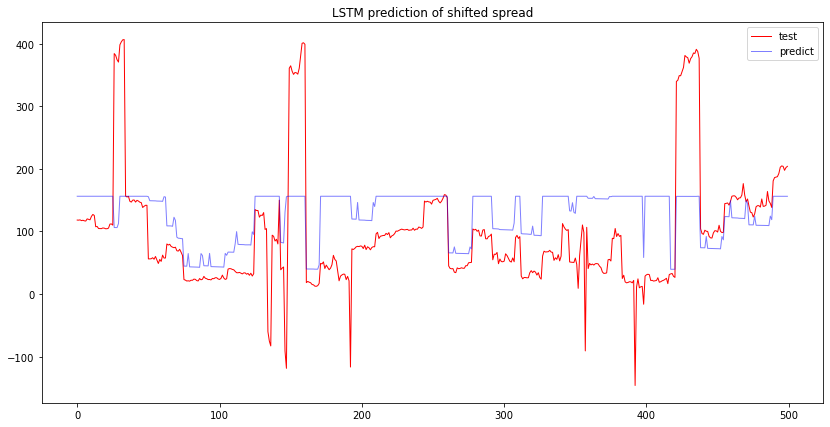

In [849]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(range(len(y_test[:500])),y_test[:500],color="red",label="test",lw=1)
plt.plot(range(len(test_output.ravel()[:500])),test_output.ravel()[:500],color="b",label="predict",lw=1,alpha=0.5)
plt.legend()
plt.title('LSTM prediction of shifted spread')
plt.show()
plt.close()

In [ ]:
#KS-Test
statistic, p_value = kstest(y_test, test_output)

print("KS statistic:", statistic)
print("P-value:", p_value)

# AR1

In [844]:
X_train1=X_train.drop('ISIN',axis=1)
y_train1 = y_train

X_test1 =X_test.drop('ISIN',axis=1)
y_test1 = y_test

In [845]:
from statsmodels.tsa.ar_model import AutoReg

# Extract time-series data
index = pd.to_datetime(X_train1.index)
time_series = pd.Series(data=y_train1, index=index)

# Create an AutoRegression model
model = AutoReg(time_series, lags=1)

# Fit the model
results = model.fit()

# Display the estimated model parameters
print(results.summary())
# Extract time-series data for the test set
test_index = pd.to_datetime(X_test1.index)
test_time_series = pd.Series(data=y_test1, index=test_index)

# Predict the values for the test set
pred = results.predict(start=len(time_series), end=len(time_series) + len(test_time_series) - 1).values

/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/ar_model.py:1156: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(lag_repr) ** -1
/Users/chloe0625/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/chloe0625/opt/anaconda3/lib/python3.9/site

                            AutoReg Model Results                             
Dep. Variable:         spread_shifted   No. Observations:               113717
Model:                     AutoReg(1)   Log Likelihood             -482262.803
Method:               Conditional MLE   S.D. of innovations             16.810
Date:                Thu, 31 Aug 2023   AIC                         964531.605
Time:                        03:13:04   BIC                         964560.530
Sample:                             1   HQIC                        964540.333
                               113717                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9488      0.080     24.352      0.000       1.792       2.106
spread_shifted.L1     0.9831      0.001   1810.893      0.000       0.982       0.984
                        

In [846]:
# MSE
mse = mean_squared_error(y_test1, pred)
print("Mean Squared Error (MSE):", mse)

# RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# MAE
mae = mean_absolute_error(y_test1, pred)
print("Mean Absolute Error (MAE):", mae)

# R-squared
r2 = r2_score(y_test1, pred)
print("R-squared:", r2)

Mean Squared Error (MSE): 8799.417092757763
Root Mean Squared Error (RMSE): 93.8052082389766
Mean Absolute Error (MAE): 73.34426105981696
R-squared: -0.01314450862525729


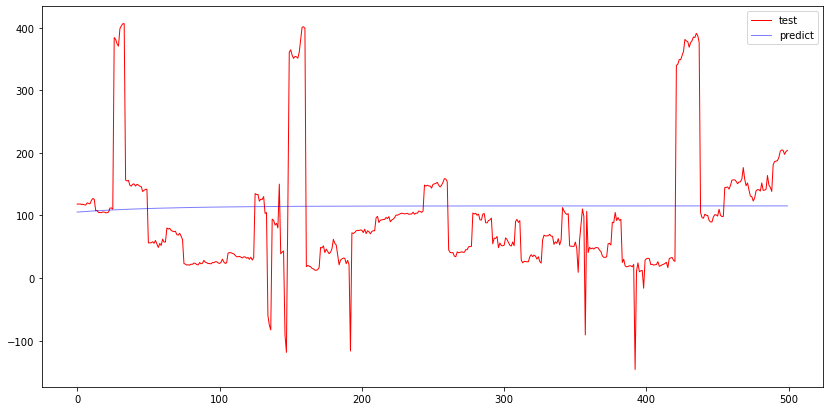

In [847]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.plot(range(len(y_test[:500])),y_test[:500],color="red",label="test",lw=1)
plt.plot(range(len(pred[:500])),pred[:500],color="b",label="predict",lw=1,alpha=0.5)
plt.legend()
plt.show()
plt.close()

In [848]:
#KS-Test
statistic, p_value = kstest(y_test, test_output)

print("KS statistic:", statistic)
print("P-value:", p_value)

KS statistic: 0.28880498010001016
P-value: 0.0
